<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Regressao_pre%C3%A7o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as m
from scipy import stats
import matplotlib.gridspec as gridspec
from tensorflow import keras
import statsmodels.api as sm


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose

# **Tratamento dos Dados**

In [ ]:
X = pd.read_csv('X.csv').iloc[:,1:]
X.head(5)

,floors,grade,year,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,month,dia,year.1
0,2,9,2014,2,4,3.0,47.4635,1970,2340,98027,5,0.0,2014
1,1,9,2014,2,4,3.0,47.6833,2600,2380,98117,5,0.0,2014
2,2,8,2014,2,3,5.0,47.5794,2820,2820,98029,5,0.0,2014
3,2,8,2014,2,3,4.0,47.5150,3310,2380,98065,5,0.0,2014
4,1,8,2014,2,3,4.0,47.5443,2160,1850,98006,5,0.0,2014


In [ ]:
Y = pd.read_csv('Y.csv').iloc[:,1:]
Y.head(5)

,price
0,437500.0
1,790000.0
2,675000.0
3,555000.0
4,440000.0


# Rede Neural

In [ ]:
columnsMinMax = list(X.columns[:7])+list(X.columns[9:])
columnsMinMax

['floors',
 'grade',
 'year',
 'bathrooms',
 'condition',
 'bedrooms',
 'lat',
 'zipcode',
 'month',
 'dia',
 'year.1']

In [ ]:
columnsStander = list(X.columns[7:9])
columnsStander

['sqft_living', 'sqft_living15']

In [ ]:
scale_price = StandardScaler()
scale_price.fit(Y['price'].values.reshape(len(Y),1))
Y['price'] = scale_price.transform(Y['price'].values.reshape(len(Y),1))

scaleMinMax = []

for column in range(len(columnsMinMax)):
    scaleMinMax.append(StandardScaler())
    scaleMinMax[column].fit(X[columnsMinMax[column]].values.reshape(len(X),1))
    X[columnsMinMax[column]] = scaleMinMax[column].transform(X[columnsMinMax[column]].values.reshape(len(X),1))


scaleStander = []
for column in range(len(columnsStander)):
    scaleStander.append(MinMaxScaler())
    scaleStander[column].fit(X[columnsStander[column]].values.reshape(len(X),1))
    X[columnsStander[column]] = scaleStander[column].transform(X[columnsStander[column]].values.reshape(len(X),1))


In [ ]:
X

,floors,grade,year,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,month,dia,year.1
0,1.003503,1.142485,-0.690627,0.340497,0.907505,-0.398880,-0.697082,0.126792,0.334022,-0.952193,-0.505467,-1.845747,-0.690627
1,-0.808454,1.142485,-0.690627,0.340497,0.907505,-0.398880,0.889370,0.174340,0.340905,0.729900,-0.505467,-1.845747,-0.690627
2,1.003503,0.291773,-0.690627,0.340497,-0.629159,1.751570,0.139450,0.190943,0.416624,-0.914814,-0.505467,-1.845747,-0.690627
3,1.003503,0.291773,-0.690627,0.340497,-0.629159,0.676345,-0.325370,0.227925,0.340905,-0.241976,-0.505467,-1.845747,-0.690627
4,-0.808454,0.291773,-0.690627,0.340497,-0.629159,0.676345,-0.113891,0.141132,0.249699,-1.344682,-0.505467,-1.845747,-0.690627
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21603,-0.808454,-0.558939,1.447960,-1.020232,-0.629159,-0.398880,-0.660993,0.066415,0.282395,2.056885,-0.505467,1.188673,1.447960
21604,1.003503,0.291773,1.447960,0.340497,-0.629159,-1.474106,1.047438,0.081509,0.167097,1.028939,-0.505467,1.188673,1.447960
21605,-0.808454,-0.558939,1.447960,0.340497,-0.629159,1.751570,0.252768,0.119245,0.253141,-1.325992,-0.505467,-1.845747,1.447960
21606,-0.808454,-1.409651,1.447960,-1.020232,-0.629159,-1.474106,0.947833,0.083019,0.089658,0.692520,-0.505467,-0.834274,1.447960


In [ ]:
X_train,X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
Y_train,Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(13,activation='elu',input_shape=[len(X_train.columns)]),
    keras.layers.Dense(13,activation='elu'),
    keras.layers.Dense(1)
])

In [ ]:
optimizer = keras.optimizers.RMSprop(0.1,)
model.compile(
    loss='mse',
    metrics=['mae','mse','mape']
)

In [ ]:
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs = 1000,
    verbose = 0
)

In [ ]:
hist_df = pd.DataFrame(history.history)

([<matplotlib.axis.XTick at 0x7c38079467a0>,
 [Text(0, 0, '0'), Text(100, 0, '100')])

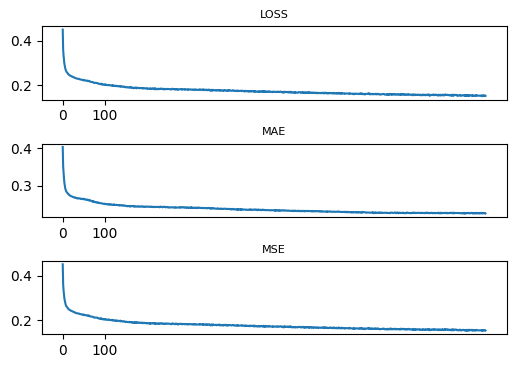

In [ ]:
fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

ax=fig.add_subplot(3,1,1)
ax.set_title('LOSS',fontsize=8)
plt.plot(hist_df.loss)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,2)
ax.set_title('MAE',fontsize=8)
plt.plot(hist_df.mae)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,3)
ax.set_title('MSE',fontsize=8)
plt.plot(hist_df.mse)
plt.xticks([0,100])

In [ ]:
metrics = model.evaluate(X_test,Y_test)
print(f"Loss = {metrics[0]}")
print(f"MAE = {metrics[1]}")
print(f"MSE = {metrics[2]}")
print(f"MAPE = {metrics[3]}")

136/136 [==============================] - 0s 1ms/step - loss: 0.2303 - mae: 0.3071 - mse: 0.2303 - mape: 489.7285
Loss = 0.23033814132213593
MAE = 0.30706268548965454
MSE = 0.23033814132213593
MAPE = 489.7285461425781


In [ ]:
predict = model.predict(X_test).flatten()

136/136 [==============================] - 0s 972us/step


In [ ]:
residuos = Y_test['price']-predict

Text(0.5, 0, 'Previsão')

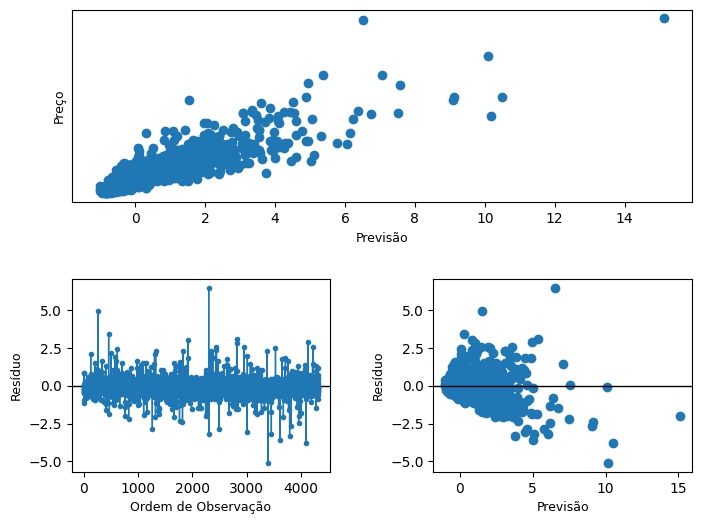

In [ ]:
fig=plt.figure(figsize=(8,6))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax=fig.add_subplot(2,2,3)

plt. axhline(y=0,xmin=0,xmax=len(residuos),color='black', linewidth=1)
plt.plot(range(len(residuos)),residuos,marker='.', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Ordem de Observação',fontsize=9)

ax=fig.add_subplot(2,1,1)

plt.scatter(predict,Y_test['price'])
plt.yticks([])
plt.ylabel('Preço', fontsize=9)
plt.xlabel('Previsão',fontsize=9)



ax=fig.add_subplot(2,2,4)

plt.scatter(predict,residuos)
plt.axhline(y=0,xmin=0,xmax=len(predict),color='black', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Previsão',fontsize=9)

In [ ]:
m.r2_score(Y_test['price'],predict)

0.7704898783032674

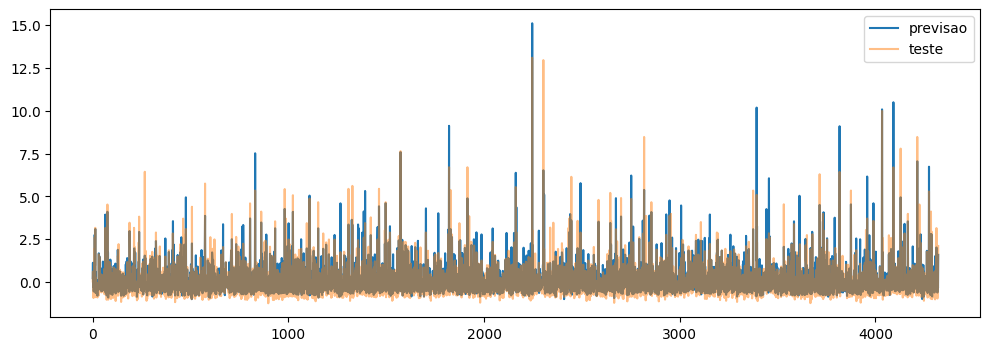

In [ ]:
ig=plt.figure(figsize=(12,4))
plt.plot(range(len(predict)),predict,label='previsao')
plt.plot(range(len(Y_test)),Y_test['price'],alpha=0.5,label='teste')
plt.legend()

# Sem as variaveis dia, mes, ano

In [ ]:
X = X[X.columns[:-3]]

In [ ]:
X_train,X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
Y_train,Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(13,activation='elu',input_shape=[len(X_train.columns)]),
    keras.layers.Dense(13,activation='elu'),
    keras.layers.Dense(1)
])

In [ ]:
optimizer = keras.optimizers.RMSprop(0.1,)
model.compile(
    loss='mse',
    metrics=['mae','mse','mape']
)

In [ ]:
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs = 1000,
    verbose = 0
)

In [ ]:
hist_df = pd.DataFrame(history.history)

([<matplotlib.axis.XTick at 0x7c38075657e0>,
 [Text(0, 0, '0'), Text(100, 0, '100')])

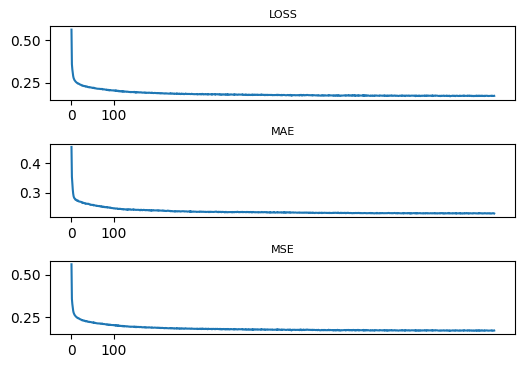

In [ ]:
fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

ax=fig.add_subplot(3,1,1)
ax.set_title('LOSS',fontsize=8)
plt.plot(hist_df.loss)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,2)
ax.set_title('MAE',fontsize=8)
plt.plot(hist_df.mae)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,3)
ax.set_title('MSE',fontsize=8)
plt.plot(hist_df.mse)
plt.xticks([0,100])

In [ ]:
metrics = model.evaluate(X_test,Y_test)
print(f"Loss = {metrics[0]}")
print(f"MAE = {metrics[1]}")
print(f"MSE = {metrics[2]}")
print(f"MAPE = {metrics[3]}")

136/136 [==============================] - 0s 1ms/step - loss: 0.2147 - mae: 0.2686 - mse: 0.2147 - mape: 379.3266
Loss = 0.2146955132484436
MAE = 0.26863425970077515
MSE = 0.2146955132484436
MAPE = 379.3266296386719


In [ ]:
predict = model.predict(X_test).flatten()

136/136 [==============================] - 0s 892us/step


In [ ]:
residuos = Y_test['price']-predict

Text(0.5, 0, 'Previsão')

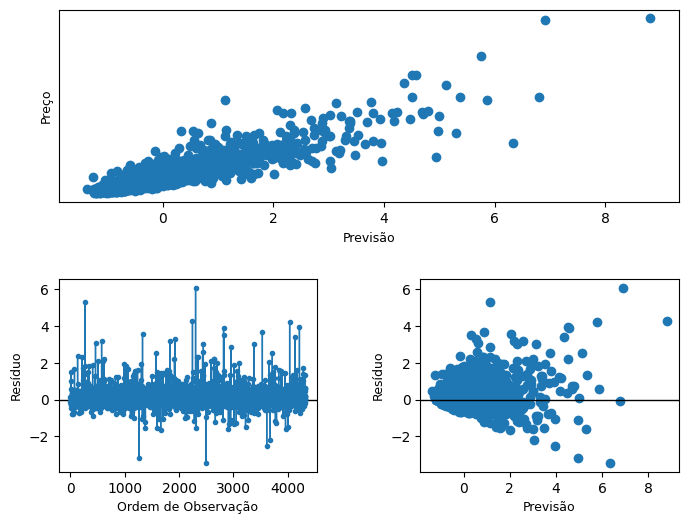

In [ ]:
fig=plt.figure(figsize=(8,6))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax=fig.add_subplot(2,2,3)

plt. axhline(y=0,xmin=0,xmax=len(residuos),color='black', linewidth=1)
plt.plot(range(len(residuos)),residuos,marker='.', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Ordem de Observação',fontsize=9)

ax=fig.add_subplot(2,1,1)

plt.scatter(predict,Y_test['price'])
plt.yticks([])
plt.ylabel([], fontsize=0)
plt.ylabel('Preço', fontsize=9)
plt.xlabel('Previsão',fontsize=9)



ax=fig.add_subplot(2,2,4)

plt.scatter(predict,residuos)
plt.axhline(y=0,xmin=0,xmax=len(predict),color='black', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Previsão',fontsize=9)

In [ ]:
m.r2_score(Y_test['price'],predict)

0.7860762833850949

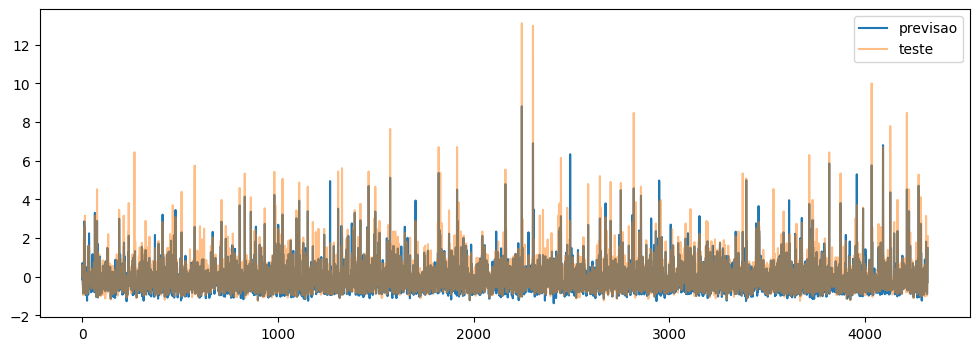

In [ ]:
ig=plt.figure(figsize=(12,4))
plt.plot(range(len(predict)),predict,label='previsao')
plt.plot(range(len(Y_test)),Y_test['price'],alpha=0.5,label='teste')
plt.legend()